<a href="https://colab.research.google.com/github/Ariara61/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_591~624.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 06. 아이템 기반 최근접 이웃 협업 필터링 실습
* 최근접 이웃 협업 필터링은 사용자 기반과 아이템 기반으로 분류
* 이 중 일반적으로 추천 정확도가 더 뛰어난 아이템 기반의 협업 필터링을 구현

### 데이터 가공 및 변환

In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


* movies.csv 파일은 영화에 대한 메타 정보인 title과 genres를 가지고 있는 영화 정보
* ratings.csv 파일은 사용자별로 영화에 대한 평점을 매긴 데이터 세트. 100,836개의 레코드 세트로서 사용자 아이디를 의미하는 userId, 영화(아이템) 아이디를 의미하는 movieId, 그리고 평점인 rating 칼럼으로 구성.
* timestamp는 현재로서는 큰 의미가 없는 칼럼.
* 평점은 최소 0.5에서 최대 5점 사이이며, 0.5 단위로 평점이 부여됨.
* 협엽 필터링: ratings.csv 데이터 세트와 같이 사용자와 아이템 간의 평점(또는 다른 유형의 액션)에 기반해 추천하는 시스템.
* 먼저 로우(행) 레벨 형태의 원본 데이터 세트를 다음 그림과 같이 모든 사용자를 로우로, 모든 영화를 칼럼으로 구성한 데이터 세트로 변경해야 함.

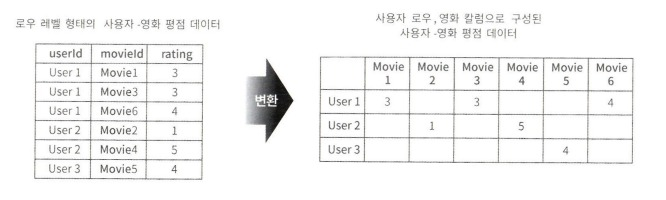

* 이 같은 변환은 DataFrame의 pivot_table() 함수를 이용하면 쉽게 할 수 있음.
* pivot_table(): 로우 레벨의 값을 칼럼으로 변경하는데 효과적.
* pivot_table()에 인자로 columns = "movieId"와 같이 부여하면 movieId 칼럼의 모든 값이 새로운 칼럼 이름으로 변환됨.

In [2]:
ratings = ratings[["userId", "movieId", "rating"]]
ratings_matrix = ratings.pivot_table("rating", index = "userId", columns = "movieId")
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* pivot_table()을 적용한 후에 movieId 값이 모두 칼럼 명으로 변환됨.
* NaN 값이 많은 이유는 사용자가 평점을 매기지 않은 영화가 칼럼으로 변환되면서 NaN으로 값이 할당됐기 때문.
* 최소 평점이 0.5이므로 NaN은 모두 0으로 변환.
* 가독성을 높이기 위해 칼럼명을 movieId가 아닌 영화명 title로 변경.
* ratings와 movies를 조인해 title 칼럼을 가져온 뒤에 pivot_table()의 인자로 colums에 "movieId"가 아닌 "title"을 입력해 title로 피벗(pivot).
* 이후 NaN은 0으로 변환

In [3]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on = "movieId")

# columns = "title"로 title 칼럼으로 피벗 수행.
ratings_matrix = rating_movies.pivot_table("rating", index = "userId", columns = "title")

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화 간 유사도 산출
* 변환된 사용자-영화 평점 행렬 데이터 세트를 이용해 영화 간의 유사도 측정.
* 영화 간의 유사도는 코사인 유사도를 기반으로 하고 사이킷런의 cosine_similarity()를 이용해 측정.
* 지금 만든 ratings_matrix 데이터 세트에 cosine_similarity()를 적용하면 영화간 유사도를 측정할 수 없음.
* cosine_similarity() 함수는 행을 기준으로 서로 다른 행을 비교해 유사도를 산출하는데, ratings_matrix는 userId가 기준인 행 레벨 데이터이므로 여기에 cosine_similarity()를 적용하면 영화 간의 유사도가 아닌 사용자 간의 유사도가 만들어짐.

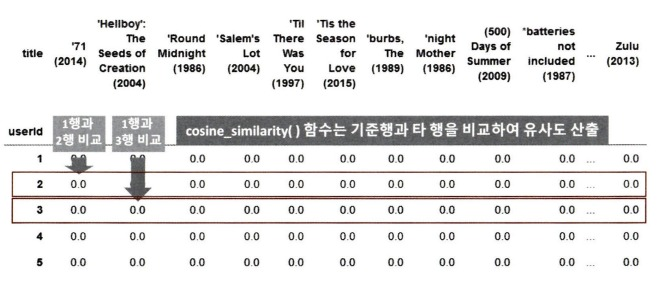

* 영화를 기준으로 cosine_similarity()를 적용하려면 현재의 ratings_matrix가 행 기준이 영화가 되고 열 기준이 사용자가 돼야 함.
* 그렇게 하려면 ratings_matrix 데이터의 행과 열의 위치를 변경해야 함.
* 이 같은 전치 행렬 변경을 위해 transpose() 함수를 제공.

In [4]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* ratings_matrix를 전치 행렬 형식으로 변경한 데이터 세트를 기반으로 영화의 코사인 유사도를 구함.
* 그리고 좀 더 직관적인 영화의 유사도 값을 표현하기 위해 cosine_similarity()로 반환된 넘파이 행렬에 영화명을 매핑해 DataFrame으로 변환

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data = item_sim, index = ratings_matrix.columns,
                           columns = ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


* cosine_similarity()를 적용한 결과 9719 x 9719 Shape으로 영화의 유사도 행렬인 item_sim이 생성됨.
* item_sim을 DataFrame으로 변환한 item_sim_df를 이용해 영화 "대부"와 유사도가 높은 상위 6개의 영화를 추출

In [6]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending = False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

* 기존 영화인 "대부"를 제외하면 "대부-2편"이 가장 유사도가 높음. 그 뒤를 마틴 스콜세지 감독의 "좋은 친구들"이 잇고 있음.
* 앞의 콘텐츠 기반 필터링과 다른 점은 "뻐꾸기 둥지 위로 날아간 새", "스타워즈 1편"과 같이 장르가 완전히 다른 영화도 유사도가 매우 높게 나타났다는 것.
* 이번에는 다른 훌륭한 영화인 "인셉션"과 높은 영화를 추출.

In [7]:
item_sim_df["Inception (2010)"].sort_values(ascending = False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

* "다크나이트"가 가장 유사도가 높음. 그 뒤를 이어서 주로 스릴러와 액션이 가미된 좋은 영화가 높은 유사도를 나타냄.
* 만들어진 아이템 기반 유사도 데이터는 사용자의 평점 정보를 모두 취합해 영화에 따라 유사한 다른 영화를 추천할 수 있게 해줌.

### 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천
* 아이템 기반의 영화 유사도 데이터는 모든 사용자의 평점을 기준으로 영화의 유사도를 생성했고, 이를 이용해 훌륭한 영화를 추천할 수 있었음.
* 하지만 이는 개인적인 취향을 반영하지 않고 영화 간의 유사도만을 가지고 추천한 것.
* 이번 절에서는 영화 유사도 데이터를 이용해 최근접 이웃 협업 필터링으로 개인에게 최적화된 영화 추천을 구현.
* 아직 관람하지 않은 영화에 대해서 아이템 유사도와 기존에 관람한 영화의 평점 데이터를 기반으로 해 새롭게 모든 영화의 예측 평점을 계산한 후 높은 예측 평점을 가진 영화를 추천하는 방식.
* 식
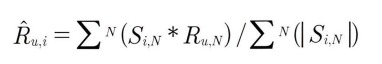


 * $\hat{R}_{u, i}$: 사용자 u, 아이템 i의 개인화된 예측 평점 값
 * $S_{i, N}$: 아이템 i와 가장 유사도가 높은 Top-N개 아이템의 유사도 벡터
 * $R_{u, N}$: 사용자 u와 아이템 i와 가장 유사도가 높은 Top-N개 아이템에 대한 실제 평점 벡터
* 여기에서 $S_{i, N}$와 $R_{u, N}$에 나오는 N 값은 아이템의 최근접 이웃 범위 계수를 의미. 이는 특정 아이템과 유사도가 가장 높은 Top-N개의 다른 아이템을 추출하는 데 사용.
* 먼저 N의 범위에 제약을 두지 않고 모든 아이템으로 가정하고 예측 평점을 구하는 로직을 작성한 뒤에 Top-N 아이템을 기반으로 협업 필터링을 수행하는 로직으로 변경.
* predict_rating(): 사용자별로 최적화된 평점 스코어를 예측하는 함수. 인자로 사용자-영화 평점 넘파이 행렬과 영화 간의 유사도를 가지는 넘파이 행렬을 입력받고 이를 이용해 개인화된 예측 평점을 계산.
* N의 범위에 제약을 두지 않는다면 사용자별 영화 예측 평점 $R_{u, N}$는 사용자 u의 모든 영화에 대한 실제 평점과 영화 i의 다른 모든 영화와의 코사인 유사도를 벡터 내적 곱한 값을 정규화를 위해 나눈 것을 의미.


In [8]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis = 1)])
  return ratings_pred

* predict_ratings()를 이용해 개인화된 예측 평점을 구함

In [9]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data = ratings_pred, index = ratings_matrix.index,\
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


* 예측 평점이 사용자별 영화의 실제 평점과 영화의 코사인 유사도를 내적한 값이기 때문에 기존에 영화를 관람하지 않아 0에 해당했던 실제 영화 평점이 예측에서는 값이 부여되는 경우가 많이 발생함.
* 예측 평점이 실제 평점에 비해 작을 수 있으며, 이는 내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문에 생기는 현상.
* 이 에측 결과가 원래의 실제 평점과 얼마나 차이가 나는지 확인. 예측 평가 지표는 MSE를 적용.
* MSE를 적용할 때에는 실제와 예측 평점의 차이는 기존에 평점이 부여된 데이터에 대해서만 오차 정도를 측정.

In [10]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 평가 MSE를 구함.
def get_mse(pred, actual):
  # 평점이 있는 실제 영화만 추출
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print("아이템 기반 모든 최근접 이웃 MSE: ", get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE:  9.895354759094706


* MSE: 약 9.89
* MSE를 감소시키는 방향으로 개선해야 함.
* predict_rating()은 많은 영화의 유사도 벡터를 이용하다 보니 상대적으로 평점 예측이 떨어짐.
* 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터를 적용하는 함수로 변경.
* predict_rating_topsim(ratings_arr, item_sim_arr, N = 20) 함수는 N 인자를 가지고 있어서 TOP-N 유사도를 가지는 영화 유사도 벡터만 예측값을 계산하는 데 적용.
* 이러한 계산을 위해서는 개별 예측값을 구하기 위해서 행, 열 별로 for 루프를 반복 수행하면서 TOP-N 유사도 벡터를 계산해야 하기 때문에 수행시간이 오래 걸림.

In [11]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n = 20):
  # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
  pred = np.zeros(ratings_arr.shape)

  # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행.
  for col in range(ratings_arr.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
    top_n_items = [np.argsort(item_sim_arr[:, col])[:n-1:-1]]
    # 개인화된 예측 평점을 계산
    for row in range(ratings_arr.shape[0]):
      pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row,
                                                                         :][top_n_items].T)
      pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))

  return pred

In [12]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n = 20)
print("아이템 기반 최근접 TOP-20 이웃 MSE: ", get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data = ratings_pred, index = ratings_matrix.index,
                                   columns = ratings_matrix.columns)

아이템 기반 최근접 TOP-20 이웃 MSE:  9.895354759094706


* MSE가 약 3.69로 기존의 9.89보다 많이 향상됨.
* userId = 9인 사용자에 대해 영화 추천.

In [13]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[user_rating_id > 0].sort_values(ascending = False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

* "오스틴 파워", "반지의 제왕" 등 대작 영화나 어드벤처 영화, 코미디 영화 등 전반적으로 흥행성이 좋은 영화에 높은 평점을 주고 있음.
* 이 사용자에게 아이템 기반 협업 필터링을 통해 영화를 추천.
* get_unseen_movies(): 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수

In [14]:
def get_unseen_movies(ratings_matrix, userId):
  # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임.
  user_rating = ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦.
  already_seen = user_rating[user_rating > 0].index.tolist()

  # 모든 영화명을 list 객체로 만듦.
  movies_list = ratings_matrix.columns.tolist()

  # list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함.
  unseen_list = [movie for movie in movies_list if movie not in already_seen]

  return unseen_list

* 사용자가 영화의 평점을 주지 않은 추천 대상 영화 정보와 predict_rating_topsim()에서 추출한 내용자별 아이템 유사도에 기반한 예측 평점 데이터 세트를 이용해 최종적으로 사용자에게 영화를 추천하는 함수인 recomm_movie_by_userid()를 생성.
* 해당 함수는 예측 평점 DataFrame과 추천하려는 사용자id, 추천 후보 영화 리스트, 추천 상위 영화 개수를 인자로 받아서 사용자가 좋아할 만한 가장 높은 예측 평점을 가진 영화를 추천.

In [15]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
  # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
  # 가장 예측 평점이 높은 순으로 정렬함.
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending = False)[:top_n]
  return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index,
                             columns = ["pred_score"])
recomm_movies

,pred_score
title,
Venom (1982),0.303278
Dr. Goldfoot and the Bikini Machine (1965),0.258705
Frankie and Johnny (1966),0.234754
English Vinglish (2012),0.214774
"Harmonists, The (1997)",0.169338
"Passenger, The (Professione: reporter) (1975)",0.163884
"Marriage of Maria Braun, The (Ehe der Maria Braun, Die) (1979)",0.163884
"Child, The (L'enfant) (2005)",0.163884
3:10 to Yuma (1957),0.163884


* "슈렉", "스파이더 맨", "인디아나 존스-2편", "매트릭스" 등 다양하지만 높은 흥행성을 가진 작품이 추천됨.

## 07. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습
* 행렬 분해를 이용해 잠재 요인 협업 필터링을 직접 구혀.
* 행렬 분해 잠재 요인 협업 필터링은 SVD나 NMF 등을 적용할 수 있는데, 일반적으로 행렬 분해에는 SVD가 자주 사용되지만 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 널 데이터가 많기 때문에 주로 SGD나 ALS 기반의 행렬 분해를 이용함.
* 여기서는 SGD 기반의 행렬 분해를 구현하고 이를 기반으로 사용자에게 영화 추천.



In [16]:
def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [17]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0

    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트.
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

* 영화 평점 행렬 데이터를 새롭게 DataFrame으로 로딩한 뒤에 다시 사용자-아이템 평점 행렬로 생성

In [18]:
import pandas as pd
import numpy as np

movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
ratings = ratings[["userId", "movieId", "rating"]]
ratings_matrix = ratings.pivot_table("rating", index = "userId", columns = "movieId")

# title 칼럼을 얻기 위해 moveis와 조인 수행
rating_movies = pd.merge(ratings, movies, on = "movieId")

# columns = "title"로 title 칼럼으로 pivot 수행.
ratings_matrix = rating_movies.pivot_table("rating", index = "userId", columns = "title")

* 다시 만들어진 사용자-아이템 평점 행렬을 matrix_factorization() 함수를 이용해 행렬 분해.

In [19]:
P, Q = matrix_factorization(ratings_matrix.values, K = 50, steps = 200, learning_rate = 0.01,
                            r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

* 반환된 예측 사용자-아이템 평점 행렬을 영화 타이틀을 칼럼명으로 가지는 DataFrame으로 변경

In [20]:
ratings_pred_matrix = pd.DataFrame(data = pred_matrix, index = ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


* 이렇게 만들어진 예측 사용자-아이템 평점 행렬 정보를 이용해 개인화된 영화 추천을 시행

In [21]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index,
                             columns = ["pred_score"])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


* 앞 절의 아이템 기반 협업 필터링 결과와는 추천된 영화가 많이 다름.
* 훌륭한 영화지만 약간 어둡고 무거운 주제의 영화가 추천됨.

## 08. 파이썬 추천 시스템 패키지 - Surprise

### Suprise 패키지 소개
* 앞에서 다룬 콘텐츠 기반 필터링, 아이템 기반 협업 필터링, 잠재 요인 기반 협업 필터링은 최적화나 수행 속도 측면에서 좀 더 보완이 필요.
* 추천 시스템은 상업적으로 가치가 크기 때문에 별도의 패키지로 제공되면 매우 활용도가 높음.
* Surprise: 파이썬 기반에서 사이킷런과 유사한 API와 프레임워크를 제공.


In [22]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163483 sha256=7ef60f79ebe9d7c11358bfcf0aaaa8b018aa4473398172fe0ab8612ee8654d50
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


* 주요 장점
 * 다양한 추천 알고리즘
 * Surprise의 핵심 API는 사이킷런의 핵심 API와 유사한 API로 작성됨.

### Surprise를 이용한 추천 시스템 구축
* 추천 데이터를 학습용과 테스트용 데이터 세트로 분리한 뒤 SVD 행렬 분해를 통해 잠재 요인 협업 필터링을 수행

In [23]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

* Surprise에서 데이터 로딩은 Dataset 클래스를 이용해서만 가능.
* Surprise는 userId, movieId, rating과 같은 주요 데이터가 로우 레벨 형태로 돼 있는 포맷의 데이터만 처리.
* Suprise는 무비렌즈 사이트에서 제공하는 과거 버전의 데이터 세트를 가져오는 API를 제공.

In [24]:
data = Dataset.load_builtin("ml-100k")
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size = 0.25, random_state = 0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


* Surprise에서 사용하는 "ml-100k" 데이터 세트는 앞 예제에서 지금까지 사용한 파일과는 차이가 있음.
* 무비렌즈 사이트에서 직접 내려받은 데이터는 최근 영황 ㅔ대한 평점 정보를 가지고 있지만, Surprise가 내려받은 데이터는 과거 버전의 데이터 세트.
* Surprise에 사용자-아이템 평점 데이터를 적용할 때 주의할 점은 무비렌즈 사이트에서 내려받은 데이터 파일과 동일하게 로우 레벨의 사용자-아이템 평점 데이터를 그대로 적용해야 한다는 것. Surprise는 자체적으로 로우 레벨의 데이터를 칼럼 레벨의 데이터로 변경하므로 원본인 로우 레벨의 사용자-아이템 평점 데이터를 데이터 세트로 적용해야 함.
>
* SVD로 잠재 요인 협업 필터링을 수행.

In [25]:
algo = SVD()
algo.fit(trainset)

* 학습된 추천 알고리즘을 기반으로 테스트 데이터 세트에 대해 추천을 수행.
* Surprise에서 추천을 예측하는 메서드는 test()와 predict()
 * test(): 사용자-아이템 펴점 데이터 세트 전체에 대해서 추천을 예측하는 메서드
 * predict(): 개별 사용자와 영화에 대한 추천 평점을 반환

In [26]:
predictions = algo.test(testset)
print("prediction type: ", type(predictions), "size: ", len(predictions))
print("prediction 결과의 최초 5개 추출")
predictions[:5]

prediction type:  <class 'list'> size:  25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.691991813467798, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.705707305506705, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.054191985450693, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.4039506443621894, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.2251276456948292, details={'was_impossible': False})]

* test 메서드의 호출 결과는 파이썬 리스트이며 크기는 입력 인자 데이터 세트의 크기와 같은 25,000개.
* Prediction 객체는 Surprise 패키지에서 제공하는 데이터 타입이며, 개별 사용자 아이디, 영화 아이디와 실제 평점 정보에 기반해 Surprise의 추천 예측 평점 데이터를 튜플 형태로 가지고 있음.
* Prediction 객체의 details 속성은 내부 처리 시 추천 예측을 할 수 없는 경우에 로그용으로 데이터를 남기는 데 사용됨.
* "was_impossible"이 True이면 예측값을 생성할 수 없는 데이터라는 의미. 여기서는 모두 False.
* 리스트 객체 내에 내포된 Prediction 객체의 uid, iid, r_ui, est 등의 속성에 접근하려면 객체명.uid와 같은 형식으로 가능.

In [27]:
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.691991813467798),
 ('882', '291', 3.705707305506705),
 ('535', '507', 4.054191985450693)]

* predict()를 이용해 추천 예측
* predict()는 개별 사용자의 아이템에 대한 추천 평점을 예측. 인자로 개별 사용자 아이디, 아이템 아이디를 입력하면 추천 예측 평점을 포함한 정보를 반환.

In [28]:
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함.
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.14   {'was_impossible': False}


* test() 메서드는 입력 데이터 세트의 모든 사용자와 아이템 아이디에 대해서 predict()를 반복적으로 수행한 결과.
>
* 테스트 데이터 세트를 이용해 추천 예측 평점과 실제 평점과의 차이를 평가
* Surprise의 accuracy 모듈은 RMSE, MSE 등의 방법으로 추천 시스템의 성능 평가 정보를 제공

In [29]:
accuracy.rmse(predictions)

RMSE: 0.9492


0.9491839577460947

### Surprise 주요 모듈 소개

#### Dataset
* Surprise는 데이터가 로우 레벨로 된 데이터 세트만 적용할 수 있음.
* 데이터의 첫 번째 칼럼을 사용자 아이디, 두 번째 칼럼을 아이템 아이디, 세 번째 칼럼을 평점으로 가정해 데이터를 로딩하고 네 번째 칼럼부터는 아예 로딩을 수행하지 않음.

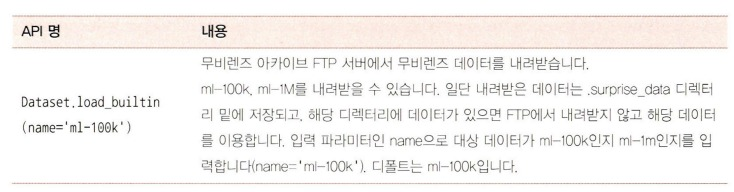

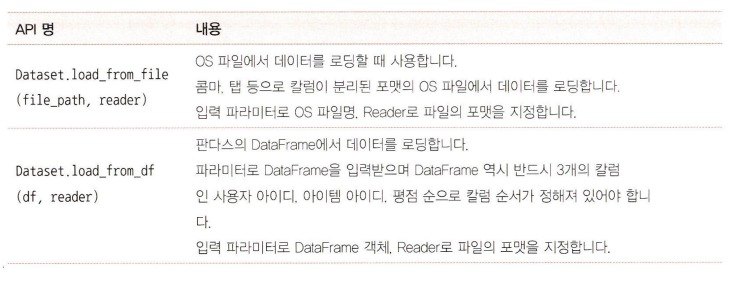

#### OS 파일 데이터를 Surprise 데이터 세트로 로딩
* Dataset.load_from_file API를 이용해 지정된 디렉터리에 있는 사용자-아이템 평점 데이터를 로딩
* Surprise에 OS 파일을 로딩할 때의 주의할 점은 로딩되는 데이터 파일에 칼럼명을 가지는 헤더 문자열이 있어서는 안 된다는 것.

In [30]:
import pandas as pd

ratings = pd.read_csv("ratings.csv")
# ratings_noh.csv 파일로 언로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성.
ratings.to_csv("ratings_noh.csv", index = False, header = False)

* ratings_noh.csv 파일은 ratings.csv 파일에서 헤더가 삭제된 파일.
* ratings_noh.csv를 DataSet 모듈의 load_from_file()을 이용해 DataSet로 로드.
* Dataset.load_from_file()을 적용하기 전에 Reader 클래스를 이용해 데이터 파일의 파싱 포맷을 저으이해야 함.
* Reader 클래스는 로딩될 ratings_noh.csv 파일의 파싱 정보를 알려주기 위해 사용됨.


In [31]:
from surprise import Reader

reader = Reader(line_format = "user item rating timestamp", sep = ",", rating_scale = (0.5, 5))
data = Dataset.load_from_file("ratings_noh.csv", reader = reader)

* Surprise 데이터 세트는 기본적으로 무비렌즈 데이터 형식을 따르므로 무비렌즈 데이터 형식이 아닌 다른 OS 파일의 경우 Reader 클래스를 먼저 설정해야 함.
* Reader 클래스의 주요 생성 파라미터
 * line_format (string): 칼럼을 순서대로 나열
 * sep (char): 칼럼을 분리하는 분리자이며, 디폴트는 "\t"
 * rating_scale (tuple, optional): 평점 값의 최소 ~ 최대 평점을 설정


In [32]:
trainset, testset = train_test_split(data, test_size = 0.25, random_state = 0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors = 50, random_state = 0)

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

#### 판다스 DataFrame에서 Surprise 데이터 세트로 로딩
* Dataset.load_from_df()를 이용하면 판다스의 DataFrame에서도 Surprise 데이터 세트로 로딩할 수 있음.
* 주의할 점은 DataFrame 역시 사용자 아이디, 평점 칼럼 순서를 지켜야 한다는 것.

In [33]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv("ratings.csv")
reader = Reader(rating_scale = (0.5, 5.0))

# ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다.
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
trainset, testset = train_test_split(data, test_size = 0.25, random_state = 0)

algo = SVD(n_factors = 50, random_state = 0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

#### Surprise 추천 알고리즘 클래스
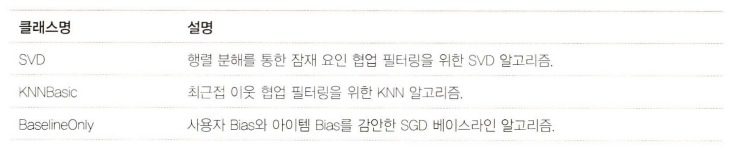

* Surprise SVD의 비용 함수는 사용자 베이스라인 편향성을 감안한 평점 예측에 Regularization을 적용한 것
 * 사용자 예측 Rating: $\hat{r}ui = \mu + b\mu + bi + qTipu$
 * Regularization을 적용한 비용 함수: $\sum(rui - \hat{r}ui)2 + \lambda(b2i+b2u+||qi||2 + ||pu||2)$
* SVD 클래스의 입력 파라미터
 * n_factors: 잠재 요인 K의 개수
 * n_epochs: SGD 수행 시 반복 횟수
 * biased (bool): 베이스라인 사용자 편향 적용 여부

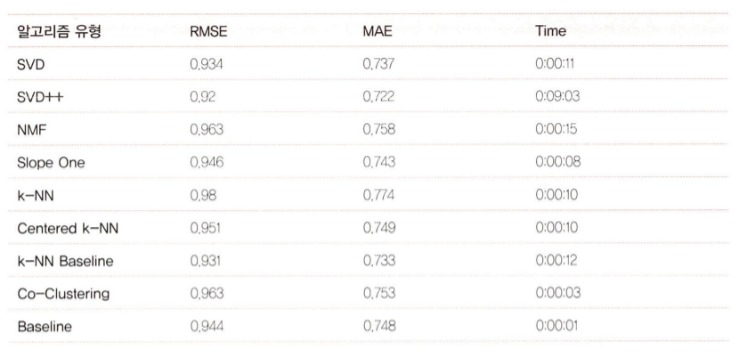

* SVD++ 알고리즘의 RMSE, MAE 성적이 가장 좋지만, 상대적으로 시간이 너무 오래 걸려 데이터가 조금만 더 커져도 사용하기 어려울 것으로 보임.
* SVD++를 제외하면 SVD와 k-NN Baseline이 가장 성능 평가 수치가 좋음. k-NN 자체는 성능이 상대적으로 뒤지지만, Baseline을 결합한 경우 성능 평가 수치가 대푝 향상됨.
* Baseline: 각 개인이 평점을 부여하는 성향을 반영해 평점을 계산하는 방식.

### 베이스라인 평점
* 각 개인의 성향에 따라 같은 아이템이더라도 평가가 달라질 수 있음. 이러한 개인의 성향을 반영해 아이템 평가에 편향성 요소를 반영하여 부과하는 것을 베이스라인 평점이라고 함.
* 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수 공식으로 계산
 * 전체 평균 평점 = 모든 사용자의 아이템에 대한 평점을 평균한 값
 * 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점
 * 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점
* 모든 사용자의 평균적인 영화 평점이 3.5이고 "어벤저스 3편"을 모든 사용자가 평균적으로 평점 4.2로 평가했다면 영화 평가를 늘 깐깐하게 하는 사용자 A가 "어벤저스 3편"을 어떻게 평가할 것인지 예상.
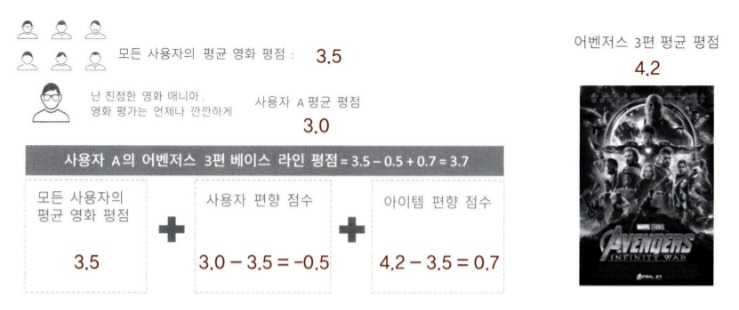

* 전체 영화의 평균 평점은 3.5이고 사용자 편향 점수는 사용자 A의 평균 영화 평점인 3.0 - 3.5 = -0.5, 아이템 편향 점수는 "어벤저스 3"의 평균 평점 4.2 - 3.5 = 0.7로 계산.
* 따라서 사용자 A의 "어벤저스 3"의 베이스라인 평점은 3.5 - 0.5 + 0.7 = 3.7

### 교차 검증과 하이퍼 파라미터 튜닝
* Surprise는 교차 검증과 하이퍼 파라미터 튜닝을 위해 사이킷런과 유사한 cross_validate()와 GridSearchCV 클래스를 제공.
* cross_validate()는 surprise.model_selection 모듈 내에 존재하며, 포륻된 데이터 세트의 개수와 성능 측정 방법을 명시해 교차 검증을 수행.


In [34]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv("ratings.csv")    # reading data in pandas df
reader = Reader(rating_scale = (0.5, 5.0))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

algo = SVD(random_state = 0)
cross_validate(algo, data, measures = ["RMSE", "MAE"], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8724  0.8729  0.8735  0.8726  0.8834  0.8750  0.0042  
MAE (testset)     0.6709  0.6706  0.6680  0.6725  0.6800  0.6724  0.0041  
Fit time          2.99    1.66    1.70    1.64    1.70    1.94    0.53    
Test time         0.15    0.29    0.13    0.14    0.13    0.17    0.06    


{'test_rmse': array([0.8724035 , 0.87288946, 0.87345643, 0.87262857, 0.88337819]),
 'test_mae': array([0.67085041, 0.67056714, 0.66798929, 0.67254846, 0.6800387 ]),
 'fit_time': (2.9906044006347656,
  1.663956642150879,
  1.695568561553955,
  1.642575979232788,
  1.6959495544433594),
 'test_time': (0.14511370658874512,
  0.2915623188018799,
  0.12839293479919434,
  0.14003205299377441,
  0.13321375846862793)}

* cross_validate()는 위의 출력 결과와 같이 폴드별 성능 평가 수치와 전체 폴드의 평균 성능 평가 수치를 함께 보여줌.
* Surprise의 GridSearchCV도 사이킷런의 GridSearchCV와 유사하게 교차 검증을 통한 하이퍼 파라미터 최적화를 수행.
* 하이퍼 파라미터 최적화는 알고리즘의 유형에 따라 다를 수 있지만, SVD의 경우 주로 SGD의 반복 횟수를 지정하는 n_epochs와 SVD의 잠재 요인 K의 크기를 지정하는 n_factors를 튜닝.


In [35]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정.
param_grid = {"n_epochs": [20, 40, 60], "n_factors": [50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures = ["rmse", "mae"], cv = 3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.8783763629335608
{'n_epochs': 20, 'n_factors': 50}


* "n_epochs":20, "n_factors": 50일 때 3개 폴드의 검증 데이터 세트에서 최적 RMSE가 0.877로 도출됨.

### Surprise를 이용한 개인화 영화 추천 시스템 구축
* 지금까지 살펴본 Surprise 예제는 학습 데이터로 fit()을 호출해 학습한 뒤 테스트 데이터로 test()를 호출해 예측 평점을 계산하고 MSE/RMSE로 성능을 평가했음.
* 이제는 Surprise 패키지로 학습된 추천 알고리즘을 기반으로 특정 사용자가 아직 평점을 매기지 않은 영화 중에서 개인 취향에 가장 적절한 영화를 추천.


In [36]:
# 다음 코드는 train_test_split()으로 분리되지 않는 데이터 세트에 fit()을 호출해 오류가 발생합니다.
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
algo = SVD(n_factors = 50, random_state = 0)
algo.fit(data)

AttributeError: ignored

* 데이터 세트 전체를 학습 데이터로 사용하려면 DataAutoFolds 클래스를 이용.
* DataAutoFolds 객체를 생성한 뒤에 build_full_trainset() 메서드를 호출하면 전체 데이터 학습 데이터 세트로 만들 수 있음.

In [39]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format = "user item rating timestamp", sep = ",", rating_scale = (0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성.
data_folds = DatasetAutoFolds(ratings_file = "ratings_noh.csv", reader = reader)

# 전체 데이터를 학습 데이터로 생성함.
trainset = data_folds.build_full_trainset()

* DatasetAutoFolds의 build_full_trainset() 메서드를 이용해 생성된 학습 데이터를 기반으로 학습을 수행
* 이후 특정 사용자에 영화를 추천하기 위해 아직 보지 않은 영화 목록을 확인

In [40]:
algo = SVD(n_epochs = 20, n_factors = 50, random_state = 0)
algo.fit(trainset)

* 특정 사용자는 userId = 9인 사용자로 지정.
* userId 9가 아직 평점을 매기지 않은 영화를 movieId 42로 선정한 뒤 예측 평점을 계산

In [41]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv("movies.csv")

# userId = 9인 movieId 데이터를 추출해 movieId = 42 데이터가 있는지 확인.
movieIds = ratings[ratings["userId"] == 9]["movieId"]

if movieIds[movieIds == 42].count() == 0:
  print("사용자 아이디 9는 영화 아이디 42의 평점 없음")

print(movies[movies["movieId"] == 42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


* movieId 42인 영화에 대해서 userId 9 사용자의 추천 예상 평점은 predict() 메서드를 이용.

In [44]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose = True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


* 추천 예측 평점은 est 값으로 3.13
>
* 사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤에 예측 평점 순으로 영화를 추천

In [46]:
def get_unseen_surprise(ratings, movies, userId):
  # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
  seen_movies = ratings[ratings["userId"] == userId]["movieId"].tolist()

  # 모든 영화의 movieId를 리스트로 생성
  total_movies = movies["movieId"].tolist()

  # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
  unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
  print("평점 매긴 영화 수: ", len(seen_movies), "추천 대상 영화 수: ", len(unseen_movies),
        "전체 영화 수: ", len(total_movies))

  return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수:  46 추천 대상 영화 수:  9696 전체 영화 수:  9742


* 사용자 아이디 9번은 전체 9742개의 영화 중에서 46개만 평점을 매겼음. 따라서 추천 대상 영화는 9696개이며, 이 중 앞에서 학습된 추천 알고리즘 클래스인 SVD를 이용해 높은 예측 평점을 가진 순으로 영화를 추천.
* recomm_movie_by_surprise()는 추천 대상 영화 모드를 대상으로 추천 알고리즘 객체의 predict() 메서드를 호출하고 그 결과인 Prediction 객체를 리스트 객체로 저장.
* 이렇게 저장된 리스트 내부의 Prediction 객체를 예측 평점이 높은 순으로 다시 정렬한 뒤 TOP-N개의 Prediction 객체에서 영화 아이디, 영화 제목, 예측 평점 정보를 추출해 반환

In [53]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n = 10):
  # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
  predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
  # [Prediction(uid = "9", iid = "1", est = 3.69), Prediction(uid = "9", iid = "2", est = 2.98),,,,]

  # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
  # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
  def sortkey_est(pred):
    return pred.est

  # sortkey_est() 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
  predictions.sort(key = sortkey_est, reverse = True)
  top_predictions = predictions[:top_n]

  # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
  top_movie_ids = [int(pred.iid) for pred in top_predictions]
  top_movie_rating = [pred.est for pred in top_predictions]
  top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]["title"]

  top_movie_preds = [(id, title, rating) for id, title, rating in \
                     zip(top_movie_ids, top_movie_titles, top_movie_rating)]

  return top_movie_preds

In [54]:
unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n = 10)

print("#### Top-10 추천 영화 리스트 ####")
for top_movie in top_movie_preds:
  print(top_movie[1], ":", top_movie[2])

평점 매긴 영화 수:  46 추천 대상 영화 수:  9696 전체 영화 수:  9742
#### Top-10 추천 영화 리스트 ####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957


* 9번 아이디 사용자에게는 브래드 피트 주연의 "세븐"과 케빈 스페이시 주연의 "유주얼 서스펙트", 그리고 "대부"와 "좋은 친구들" 같은 서스펜스/스릴러/범죄 영화 및 스타워즈 같은 액션 영화 등이 주로 추천됨.
* 이처럼 Surprise 패키지는 복잡한 알고리즘을 직접 구현하지 않고도 쉽고 간결한 API를 이용해 파이썬 기반에서 추천 시스템을 구축할 수 있도록 해줌.